In [15]:
import sys
#%cd variational_inference_for_longitudinal_data/
sys.path.append('diffusion/stable_diffusion/')
sys.path.append('diffusion/stable_diffusion/model/')
sys.path.append('lib/src/')
import torch
from torch import nn
import torch.nn.functional as F
import os
from matplotlib import pyplot as plt
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import numpy as np
import logging




from diffusion.stable_diffusion.latent_diffusion import MyLatentDiffusion, LitLDM
from diffusion.stable_diffusion.model.unet import UNetModel
from diffusion.stable_diffusion.sampler.ddim import DDIMSampler

from lib.src.pythae.models import VAE
from lib.src.pythae.models import LLDM_IAF, LVAE_IAF_Config
from lib.src.pythae.trainers import BaseTrainerConfig, BaseTrainer
from lib.scripts.utils import Encoder_Chairs,Decoder_Chairs
from lib.scripts.utils import My_MaskedDataset, make_batched_masks
from lib.src.pythae.trainers.training_callbacks import WandbCallback


def load_config_unet(config):
    return UNetModel(
        in_channels=config['in_channels'],
        out_channels=config['out_channels'],
        channels=config['channels'],
        n_res_blocks=config['n_res_blocks'],
        attention_levels=config['attention_levels'],
        channel_multipliers=config['channel_multipliers'],
        n_heads=config['n_heads'],
    )


def plot_sequence(X):

    if len(X.shape) == 4:
        X = X.unsqueeze(0)

    X = X.cpu().detach().numpy()
    num_seq = X.shape[0]
    num_obs = X.shape[1]

    logger = logging.getLogger()
    old_level = logger.level
    logger.setLevel(100)
    plt.figure(figsize=(10, 10))
    for i in range(num_seq):
        for j in range(num_obs):
            plt.subplot(num_seq, num_obs, i*num_obs+j+1)
            plt.imshow(X[i, j].transpose(1, 2, 0))
            plt.axis('off')

    plt.show()
    logger.setLevel(old_level)


%reload_ext autoreload
%autoreload 2

!nvidia-smi

Mon Jun 17 17:11:09 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.90.07              Driver Version: 550.90.07      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA RTX A2000 12GB          Off |   00000000:01:00.0  On |                  Off |
| 30%   48C    P8             12W /   70W |    2854MiB /  12282MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [5]:
PATH_DATA = 'lib/my_data/sprites/Sprites_train.pt'


train_data = torch.load(os.path.join(PATH_DATA))[:-1000, :-1, :, :, :]
eval_data = torch.load(os.path.join(PATH_DATA), map_location="cpu")[-1000:, :-1, :, :, :]
#test_data = torch.load(os.path.join('lib/my_data/sprites/Sprites_test.pt'), map_location="cpu")

print(train_data.shape)
train_data = train_data.permute(0, 1, 4, 2, 3)
eval_data = eval_data.permute(0, 1, 4, 2, 3)
#test_data = test_data.permute(0, 1, 4, 2, 3)
print(train_data.shape)

train_seq_mask = torch.ones(train_data.shape[:2], requires_grad=False).type(torch.bool)
eval_seq_mask = torch.ones(eval_data.shape[:2], requires_grad=False).type(torch.bool)
#test_seq_mask = torch.ones(test_data.shape[:2], requires_grad=False).type(torch.bool)
train_pix_mask = torch.ones_like(train_data, requires_grad=False).type(torch.bool)
eval_pix_mask = torch.ones_like(eval_data, requires_grad=False).type(torch.bool)
#test_pix_mask = torch.ones_like(test_data, requires_grad=False).type(torch.bool)

train_dataset = My_MaskedDataset(train_data, train_seq_mask, train_pix_mask)
eval_dataset = My_MaskedDataset(eval_data, eval_seq_mask, eval_pix_mask)
#test_dataset = My_MaskedDataset(test_data, test_seq_mask, test_pix_mask)

train_loader = torch.utils.data.DataLoader(train_data, batch_size=200, shuffle=True)
val_loader = torch.utils.data.DataLoader(eval_data, batch_size=200, shuffle=True)

torch.Size([8000, 7, 64, 64, 3])
torch.Size([8000, 7, 3, 64, 64])


In [7]:
# encoder = Encoder_Chairs(config)
# decoder = Decoder_Chairs(config)
# vae = LVAE_IAF(config, encoder, decoder)
PATH_VAE_FOLDER = 'pre-trained_vae/VAE_training_2024-06-16_15-12-03/final_model'
PATH_DIFFUSION_CKPT = 'ldm/lightning_logs/version_3/checkpoints/epoch=149-step=4800.ckpt'




device = 'cuda'
vae = VAE.load_from_folder(PATH_VAE_FOLDER).to(device)
vae.eval()
_, _ = vae.retrieveG(train_data, verbose = True)


# in_channels = 3
# out_channels = 3
# channels = 32
# n_res_blocks = 2
# attention_levels = [2]
# channel_multipliers = (1, 2, 4)
# n_heads = 16


in_channels = 3
out_channels = 3
channels = 64
n_res_blocks = 4
attention_levels = [0]
channel_multipliers = [1]
n_heads = 4

unet_config = {
    'in_channels': in_channels,
    'out_channels': out_channels,
    'channels': channels,
    'n_res_blocks': n_res_blocks,
    'attention_levels': attention_levels,
    'channel_multipliers': channel_multipliers,
    'n_heads': n_heads,
}

unet = load_config_unet(unet_config)

latent_scaling_factor = 1
n_steps = 1000

#Pas oublier de modif
linear_start =  0.00085
linear_end = 0.012

input_dim = (3, 64, 64)
f = 32 #subsampling factor
latent_dim = 3* (64 // f) * (64 // f)
print('Latent dim:', latent_dim)


latent_diffusion = MyLatentDiffusion(unet, latent_scaling_factor, latent_dim, n_steps, linear_start, linear_end)
print('Number of parameters in the diffusion model: ', sum(p.numel() for p in latent_diffusion.parameters() if p.requires_grad))

model = LitLDM.load_from_checkpoint(PATH_DIFFUSION_CKPT, ldm = latent_diffusion, vae = vae, latent_dim = latent_dim, lr = 6e-4).to(device)
diffusion = model.ldm

Running Kmedoids
Finding temperature
Best temperature found:  2.6125142574310303
Building metric
Increasing T by  1.5
Latent dim: 12
Number of parameters in the diffusion model:  2223043


In [20]:
model_config = LVAE_IAF_Config(
    input_dim=(3, 64, 64),
    n_obs_per_ind=train_data.shape[1], #8 for Sprites, 7 as we remove last obs
    latent_dim=latent_dim,
    beta=1,
    n_hidden_in_made=4,
    n_made_blocks=2,
    warmup=0,
    context_dim=None,
    prior='standard',
    posterior='iaf',
    linear_scheduling_steps=10,

)
training_config = BaseTrainerConfig(
        num_epochs=200,
        learning_rate=1e-3,
        batch_size=256,
        steps_saving=None,
        steps_predict=100,
        shuffle=True,
        output_dir='lldm'
    )


device = 'cuda'
encoder = Encoder_Chairs(model_config).to(device)
decoder = Decoder_Chairs(model_config).to(device)
ddim_sampler = DDIMSampler(diffusion, n_steps = train_data.shape[1]-1, ddim_eta = 1)
zT_samples = torch.load('zT_samples.pt') #shape (1000, 12)


lldm = LLDM_IAF(model_config=model_config, encoder=encoder, decoder=decoder, 
                pretrained_vae=vae, pretrained_ldm=diffusion, ddim_sampler=ddim_sampler,
                precomputed_zT_samples=zT_samples, verbose = True)

Diffusion time steps  [997 831 665 499 333 167   1]
Running on  cuda:0
Freezing pre-trained VAE and pre-trained LDM...
Freezing done.
Number of trainable parameters: 1.8e+06
Number of total parameters: 5.1e+06


In [16]:
callbacks = [] # the TrainingPipeline expects a list of callbacks
wandb_cb = WandbCallback() # Build the callback 
# SetUp the callback 
wandb_cb.setup(
    training_config=training_config, # pass the training config
    model_config = model_config,
    project_name="LLDM_new", # specify your wandb project # specify your wandb entity
)
callbacks.append(wandb_cb) 

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: meilame-tayebjee. Use `wandb login --relogin` to force relogin


In [21]:
optimizer = torch.optim.Adam(lldm.parameters(), lr=training_config.learning_rate, eps=1e-4)

### Scheduler
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.5, patience=4, verbose=True)

trainer = BaseTrainer(
            model=lldm,
            train_dataset=train_dataset,
            eval_dataset=eval_dataset,
            training_config=training_config,
            optimizer=optimizer,
            scheduler=scheduler,
            callbacks=callbacks
        )

Created lldm folder since did not exist.



In [22]:
trainer.train()

    rec_loss   reg_loss  count
0  54.485799  14.554539    5.0
1  45.426662  17.141984    4.0
2  48.407468  17.779473    5.0
3  54.966455  20.392362    9.0
4  63.849059  29.865008    5.0
5  79.305080  49.970630    7.0
6  79.146255  21.335264    1.0


Eval of epoch 122/200:   0%|          | 0/4 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 84.0278
Eval loss: 80.5223
--------------------------------------------------------------------------


Training of epoch 123/200:   0%|          | 0/32 [00:00<?, ?batch/s]

    rec_loss   reg_loss  count
0  53.030411  14.637299    1.0
1  45.492861  17.010603    6.0
2  48.180760  17.524741    5.0
3  54.973805  20.411176    5.0
4  63.773164  29.976366    8.0
5  79.458834  49.968349    6.0
6  77.829587  23.395329    5.0


Eval of epoch 123/200:   0%|          | 0/4 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 89.3355
Eval loss: 93.1717
--------------------------------------------------------------------------


Training of epoch 124/200:   0%|          | 0/32 [00:00<?, ?batch/s]

    rec_loss   reg_loss  count
0  53.906016  14.456636    5.0
1  45.589725  17.100598    6.0
2  48.103215  17.622632    8.0
3  55.247917  20.367654    6.0
4  63.079278  30.111170    3.0
5  80.940257  50.509421    3.0
6  77.156230  23.540832    5.0


Eval of epoch 124/200:   0%|          | 0/4 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 78.1929
Eval loss: 90.6963
--------------------------------------------------------------------------


Training of epoch 125/200:   0%|          | 0/32 [00:00<?, ?batch/s]

    rec_loss   reg_loss  count
0  55.122216  14.540890    8.0
1  45.440585  17.055054    4.0
2  48.646042  17.610747    5.0
3  53.611954  20.566678    2.0
4  63.814922  30.001269    2.0
5  79.931379  50.036971    8.0
6  77.062182  23.054388    7.0


Eval of epoch 125/200:   0%|          | 0/4 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 89.1356
Eval loss: 98.536
--------------------------------------------------------------------------


Training of epoch 126/200:   0%|          | 0/32 [00:00<?, ?batch/s]

    rec_loss   reg_loss  count
0  54.661804  14.602154    2.0
1  45.253809  16.988182    7.0
2  48.325190  17.825542    5.0
3  54.944816  20.586256    5.0
4  63.931371  30.150487    3.0
5  79.431981  50.178662    6.0
6  78.062970  22.890518    8.0


Eval of epoch 126/200:   0%|          | 0/4 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 86.1258
Eval loss: 75.2633
--------------------------------------------------------------------------


Training of epoch 127/200:   0%|          | 0/32 [00:00<?, ?batch/s]

    rec_loss   reg_loss  count
0  55.127029  14.560842    8.0
1  45.312094  17.116509    3.0
2  48.353694  17.586945    8.0
3  56.089291  20.522999    4.0
4  62.404841  29.800605    3.0
5  81.400812  50.402352    4.0
6  77.706432  23.095693    6.0


Eval of epoch 127/200:   0%|          | 0/4 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 83.9485
Eval loss: 79.4463
--------------------------------------------------------------------------


Training of epoch 128/200:   0%|          | 0/32 [00:00<?, ?batch/s]

    rec_loss   reg_loss  count
0  54.955959  14.582584    2.0
1  45.570849  17.117311    5.0
2  48.334381  17.792347    3.0
3  55.456777  20.398811    7.0
4  63.862822  29.901970   10.0
5  78.826996  50.228004    5.0
6  76.684898  23.381419    4.0


Eval of epoch 128/200:   0%|          | 0/4 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 88.9778
Eval loss: 94.5701
--------------------------------------------------------------------------


Training of epoch 129/200:   0%|          | 0/32 [00:00<?, ?batch/s]

    rec_loss   reg_loss  count
0  54.711238  14.643210    3.0
1  45.677962  17.075314    3.0
2  47.764765  17.659571    4.0
3  54.741128  20.550238    7.0
4  63.501809  29.785571    6.0
5  79.347674  50.024146    7.0
6  77.271843  23.343580    6.0


Eval of epoch 129/200:   0%|          | 0/4 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 89.8687
Eval loss: 103.9113
--------------------------------------------------------------------------


Training of epoch 130/200:   0%|          | 0/32 [00:00<?, ?batch/s]

    rec_loss   reg_loss  count
0  56.471230  14.548441    1.0
1  45.584245  16.960913    5.0
2  47.714483  17.541895    3.0
3  55.005216  20.456835   11.0
4  64.006473  29.927019    8.0
5  79.871432  49.953699    5.0
6  77.406588  23.603260    3.0


Eval of epoch 130/200:   0%|          | 0/4 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 84.2992
Eval loss: 77.6826
--------------------------------------------------------------------------


Training of epoch 131/200:   0%|          | 0/32 [00:00<?, ?batch/s]

    rec_loss   reg_loss  count
0  55.071843  14.509240    5.0
1  46.066299  16.933985    1.0
2  48.621391  17.679100    6.0
3  55.257045  20.518901    7.0
4  63.186298  30.081947    5.0
5  79.360956  50.022025    6.0
6  77.232323  23.127514    6.0


Eval of epoch 131/200:   0%|          | 0/4 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 89.7877
Eval loss: 88.9653
--------------------------------------------------------------------------


Training of epoch 132/200:   0%|          | 0/32 [00:00<?, ?batch/s]

    rec_loss   reg_loss  count
0  54.380276  14.664864    5.0
1  45.905978  17.056289    4.0
2  47.864601  17.760043    9.0
3  55.149719  20.475818    5.0
4  63.740162  30.126747    6.0
5  80.448088  49.823908    5.0
6  76.978676  23.708083    2.0


Eval of epoch 132/200:   0%|          | 0/4 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 82.0593
Eval loss: 89.9632
--------------------------------------------------------------------------


Training of epoch 133/200:   0%|          | 0/32 [00:00<?, ?batch/s]

    rec_loss   reg_loss  count
0  55.198480  14.424308    3.0
1  45.782047  17.001627    5.0
2  48.682026  17.657784    2.0
3  55.048875  20.588261    8.0
4  63.335262  30.062929    6.0
5  80.339342  50.046525    8.0
6  77.695986  22.990368    4.0


Eval of epoch 133/200:   0%|          | 0/4 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 90.8416
Eval loss: 82.3359
--------------------------------------------------------------------------


Training of epoch 134/200:   0%|          | 0/32 [00:00<?, ?batch/s]

    rec_loss   reg_loss  count
0  55.408062  14.443295    8.0
1  46.049347  17.236079    3.0
2  47.497950  17.677993    4.0
3  54.997273  20.478098    4.0
4  63.566141  29.948645    4.0
5  80.379375  49.919170    5.0
6  77.782056  23.078712    8.0


Eval of epoch 134/200:   0%|          | 0/4 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 87.949
Eval loss: 85.8268
--------------------------------------------------------------------------


Training of epoch 135/200:   0%|          | 0/32 [00:00<?, ?batch/s]

    rec_loss   reg_loss  count
0  55.238446  14.551342    5.0
1  46.261759  16.994952    4.0
2  48.418231  17.792492    3.0
3  54.938979  20.424647    4.0
4  63.228925  29.906243    8.0
5  80.058785  50.066482    8.0
6  77.050121  22.901065    4.0


Eval of epoch 135/200:   0%|          | 0/4 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 92.0201
Eval loss: 97.3536
--------------------------------------------------------------------------


Training of epoch 136/200:   0%|          | 0/32 [00:00<?, ?batch/s]

    rec_loss   reg_loss  count
0  54.201453  14.603292    6.0
1  45.775829  17.124363    2.0
2  48.294271  17.785822    4.0
3  54.973415  20.577712    7.0
4  63.874935  29.899436    5.0
5  80.796290  49.484028    3.0
6  77.431313  23.083294    9.0


Eval of epoch 136/200:   0%|          | 0/4 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 84.5855
Eval loss: 99.1559
--------------------------------------------------------------------------


Training of epoch 137/200:   0%|          | 0/32 [00:00<?, ?batch/s]

    rec_loss   reg_loss  count
0  55.529689  14.570909    7.0
1  45.240356  17.075149    3.0
2  48.244720  17.562123    4.0
3  54.807123  20.631555   10.0
4  62.795592  30.002842    5.0
5  81.312389  49.789372    4.0
6  77.661853  22.640245    3.0


Eval of epoch 137/200:   0%|          | 0/4 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 80.8733
Eval loss: 98.219
--------------------------------------------------------------------------


Training of epoch 138/200:   0%|          | 0/32 [00:00<?, ?batch/s]

    rec_loss   reg_loss  count
0  55.099999  14.509074    8.0
1  46.145027  16.991529    1.0
2  48.475451  17.596030    3.0
3  55.664019  20.533132    3.0
4  63.341040  29.947780   10.0
5  79.898386  50.001819    5.0
6  77.598545  23.081594    6.0


Eval of epoch 138/200:   0%|          | 0/4 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 88.7628
Eval loss: 75.5344
--------------------------------------------------------------------------


Training of epoch 139/200:   0%|          | 0/32 [00:00<?, ?batch/s]

    rec_loss   reg_loss  count
0  54.730936  14.458354    7.0
1  45.641289  17.080861    3.0
2  48.802744  17.530897    5.0
3  55.026886  20.500434    8.0
4  63.209908  30.131744    5.0
5  80.229955  50.231930    3.0
6  77.068040  23.243034    5.0


Eval of epoch 139/200:   0%|          | 0/4 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 83.3091
Eval loss: 77.8237
--------------------------------------------------------------------------


Training of epoch 140/200:   0%|          | 0/32 [00:00<?, ?batch/s]

    rec_loss   reg_loss  count
0  54.558379  14.287384    4.0
1  45.439172  17.107082    7.0
2  48.077576  17.628423    4.0
3  55.228998  20.348337    5.0
4  63.725155  29.778102    6.0
5  78.970097  50.166610    4.0
6  79.007511  22.760056    6.0


Eval of epoch 140/200:   0%|          | 0/4 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 85.3373
Eval loss: 86.7681
--------------------------------------------------------------------------


Training of epoch 141/200:   0%|          | 0/32 [00:00<?, ?batch/s]

    rec_loss   reg_loss  count
0  54.720160  14.304854    4.0
1  45.558384  17.111404    3.0
2  48.608782  17.803535    3.0
3  55.148496  20.374241    4.0
4  64.131212  29.668230    5.0
5  80.023850  50.330667    9.0
6  78.152016  22.740027    8.0


Eval of epoch 141/200:   0%|          | 0/4 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 95.8653
Eval loss: 94.6687
--------------------------------------------------------------------------


Training of epoch 142/200:   0%|          | 0/32 [00:00<?, ?batch/s]

    rec_loss   reg_loss  count
0  55.784124  14.559265    3.0
1  45.342822  17.039066    7.0
2  48.393468  17.623257   10.0
3  55.377291  20.376321    4.0
4  63.915334  29.799829    5.0
5  79.639002  50.142490    4.0
6  76.173770  22.971984    3.0


Eval of epoch 142/200:   0%|          | 0/4 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 78.6672
Eval loss: 72.3966
--------------------------------------------------------------------------


Training of epoch 143/200:   0%|          | 0/32 [00:00<?, ?batch/s]

    rec_loss   reg_loss  count
0  54.268958  14.541607    3.0
1  45.590475  17.046368    7.0
2  48.430219  17.661450    9.0
3  55.624180  20.424346    2.0
4  63.901589  29.821733    6.0
5  78.765068  50.280778    5.0
6  77.097769  23.577481    4.0


Eval of epoch 143/200:   0%|          | 0/4 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 84.7655
Eval loss: 75.9927
--------------------------------------------------------------------------


Training of epoch 144/200:   0%|          | 0/32 [00:00<?, ?batch/s]

    rec_loss   reg_loss  count
0  55.055544  14.534608    7.0
1  45.373641  17.052624    7.0
2  48.359128  17.691513    4.0
3  54.878842  20.527791    6.0
4  63.697107  29.817179    5.0
5  80.563942  49.867645    3.0
6  77.906076  22.704363    4.0


Eval of epoch 144/200:   0%|          | 0/4 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 81.1904
Eval loss: 92.4226
--------------------------------------------------------------------------


Training of epoch 145/200:   0%|          | 0/32 [00:00<?, ?batch/s]

    rec_loss   reg_loss  count
0  53.990541  14.535454    6.0
1  46.083748  17.015019    5.0
2  48.132537  17.740805    5.0
3  55.005647  20.395118    4.0
4  63.306989  29.923030    6.0
5  80.638135  49.803753    3.0
6  77.074435  23.155565    7.0


Eval of epoch 145/200:   0%|          | 0/4 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 82.5077
Eval loss: 83.0366
--------------------------------------------------------------------------


Training of epoch 146/200:   0%|          | 0/32 [00:00<?, ?batch/s]

    rec_loss   reg_loss  count
0  55.915808  14.453835    4.0
1  45.431187  17.177479    6.0
2  48.273478  17.860149    3.0
3  55.002903  20.509375    6.0
4  63.704294  30.050779    4.0
5  77.771736  50.316086    2.0
6  77.547423  22.928561   11.0


Eval of epoch 146/200:   0%|          | 0/4 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 84.7778
Eval loss: 89.1477
--------------------------------------------------------------------------


Training of epoch 147/200:   0%|          | 0/32 [00:00<?, ?batch/s]

    rec_loss   reg_loss  count
0  54.169621  14.656903    3.0
1  45.647762  17.118187    8.0
2  48.473803  17.702562    6.0
3  54.687517  20.530822    5.0
4  63.521980  29.732268    6.0
5  79.240023  50.264799    4.0
6  79.387957  22.976757    4.0


Eval of epoch 147/200:   0%|          | 0/4 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 81.6303
Eval loss: 82.7119
--------------------------------------------------------------------------


Training of epoch 148/200:   0%|          | 0/32 [00:00<?, ?batch/s]

    rec_loss   reg_loss  count
0  55.868910  14.437182    2.0
1  46.126446  16.892373    2.0
2  48.733501  17.690343    5.0
3  54.489474  20.541413    9.0
4  63.260176  29.881228    7.0
5  79.902544  49.764478    4.0
6  77.903100  23.054349    7.0


Eval of epoch 148/200:   0%|          | 0/4 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 88.1425
Eval loss: 68.076
--------------------------------------------------------------------------


Training of epoch 149/200:   0%|          | 0/32 [00:00<?, ?batch/s]

    rec_loss   reg_loss  count
0  54.550547  14.510464    5.0
1  45.796307  16.932410    7.0
2  48.093369  17.693790    7.0
3  55.362450  20.341699    3.0
4  63.604910  29.952675    5.0
5  79.562590  50.291319    5.0
6  77.257242  23.321397    4.0


Eval of epoch 149/200:   0%|          | 0/4 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 84.9718
Eval loss: 70.4881
--------------------------------------------------------------------------


Training of epoch 150/200:   0%|          | 0/32 [00:00<?, ?batch/s]

    rec_loss   reg_loss  count
0  54.312679  14.453991    5.0
1  44.402145  16.928555    3.0
2  47.931991  17.724906    4.0
3  55.619580  20.481778    7.0
4  64.325244  29.858765    4.0
5  79.592645  50.159386    7.0
6  78.421759  23.299042    6.0


Eval of epoch 150/200:   0%|          | 0/4 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 91.7667
Eval loss: 85.468
--------------------------------------------------------------------------


Training of epoch 151/200:   0%|          | 0/32 [00:00<?, ?batch/s]

    rec_loss   reg_loss  count
0  54.860681  14.414427    7.0
1  45.758850  17.042087    6.0
2  48.358521  17.690527    6.0
3  55.167322  20.466243    6.0
4  63.303975  30.056226    5.0
5  79.116577  49.767635    2.0
6  78.356077  22.884222    4.0


Eval of epoch 151/200:   0%|          | 0/4 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 78.1089
Eval loss: 80.0934
--------------------------------------------------------------------------


Training of epoch 152/200:   0%|          | 0/32 [00:00<?, ?batch/s]

    rec_loss   reg_loss  count
0  53.639607  14.592880    5.0
1  45.745732  17.059246    7.0
2  48.485465  17.840707    3.0
3  55.580650  20.516640    5.0
4  63.827137  29.964600    4.0
5  79.307390  50.091412    5.0
6  78.205535  23.239958    7.0


Eval of epoch 152/200:   0%|          | 0/4 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 86.6303
Eval loss: 88.0209
--------------------------------------------------------------------------


Training of epoch 153/200:   0%|          | 0/32 [00:00<?, ?batch/s]

    rec_loss   reg_loss  count
0  54.542047  14.421906    6.0
1  45.759377  17.110662    4.0
2  47.898711  17.729746    4.0
3  55.475887  20.577264    5.0
4  63.700237  29.772258   11.0
5  79.683701  50.175358    2.0
6  77.725235  23.046860    4.0


Eval of epoch 153/200:   0%|          | 0/4 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 82.7176
Eval loss: 99.0561
--------------------------------------------------------------------------


Training of epoch 154/200:   0%|          | 0/32 [00:00<?, ?batch/s]

    rec_loss   reg_loss  count
0  55.270015  14.453401   10.0
1  45.858023  17.247700    3.0
2  48.146427  17.747796    5.0
3  54.362240  20.572931    3.0
4  63.101143  30.198564    2.0
5  79.831337  49.886090   10.0
6  78.461833  22.863547    3.0


Eval of epoch 154/200:   0%|          | 0/4 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 88.511
Eval loss: 89.513
--------------------------------------------------------------------------


Training of epoch 155/200:   0%|          | 0/32 [00:00<?, ?batch/s]

    rec_loss   reg_loss  count
0  54.031358  14.383803    3.0
1  45.424191  17.150262   10.0
2  49.081417  17.537103    3.0
3  54.972913  20.462114    5.0
4  64.345081  29.840595    4.0
5  79.635722  50.274871    5.0
6  79.746208  22.701228    6.0


Eval of epoch 155/200:   0%|          | 0/4 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 84.0922
Eval loss: 71.2365
--------------------------------------------------------------------------


Training of epoch 156/200:   0%|          | 0/32 [00:00<?, ?batch/s]

    rec_loss   reg_loss  count
0  55.473503  14.477143    6.0
1  45.388715  17.280766    3.0
2  48.618274  17.711085    7.0
3  54.361984  20.541442    8.0
4  64.155731  30.006744    3.0
5  80.462357  50.226247    3.0
6  77.531101  23.311646    6.0


Eval of epoch 156/200:   0%|          | 0/4 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 83.3097
Eval loss: 75.954
--------------------------------------------------------------------------


Training of epoch 157/200:   0%|          | 0/32 [00:00<?, ?batch/s]

    rec_loss   reg_loss  count
0  54.977590  14.359556    4.0
1  45.690924  17.064511    7.0
2  48.168766  17.714113    4.0
3  55.547179  20.417110    6.0
4  63.319944  29.936576    7.0
5  79.025335  49.921995    4.0
6  78.014105  23.124602    4.0


Eval of epoch 157/200:   0%|          | 0/4 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 84.5399
Eval loss: 74.9499
--------------------------------------------------------------------------


Training of epoch 158/200:   0%|          | 0/32 [00:00<?, ?batch/s]

    rec_loss   reg_loss  count
0  55.268120  14.390678    6.0
1  45.470013  17.222203    2.0
2  48.479445  17.850128    4.0
3  54.913826  20.277845    1.0
4  63.257136  29.852245    6.0
5  79.245473  50.139900    8.0
6  78.135575  22.955977    9.0


Eval of epoch 158/200:   0%|          | 0/4 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 96.4878
Eval loss: 90.6966
--------------------------------------------------------------------------


Training of epoch 159/200:   0%|          | 0/32 [00:00<?, ?batch/s]

    rec_loss   reg_loss  count
0  55.609324  14.505011    6.0
1  45.526585  17.117853    5.0
2  48.057832  17.828513    7.0
3  55.122681  20.438825    2.0
4  64.091958  29.833680    7.0
5  79.886395  50.366784    4.0
6  78.155881  22.941563    5.0


Eval of epoch 159/200:   0%|          | 0/4 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 83.3571
Eval loss: 83.6713
--------------------------------------------------------------------------


Training of epoch 160/200:   0%|          | 0/32 [00:00<?, ?batch/s]

    rec_loss   reg_loss  count
0  54.426756  14.435821    5.0
1  44.976991  17.069903    4.0
2  47.897010  17.726528    7.0
3  55.564971  20.361433    9.0
4  64.086425  30.012920    5.0
5  79.291317  49.839663    4.0
6  78.636990  23.045382    2.0


Eval of epoch 160/200:   0%|          | 0/4 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 80.9657
Eval loss: 75.8456
--------------------------------------------------------------------------


Training of epoch 161/200:   0%|          | 0/32 [00:00<?, ?batch/s]

    rec_loss   reg_loss  count
0  55.392199  14.502765    2.0
1  45.762954  16.926618    7.0
2  48.221633  17.694777    7.0
3  55.604109  20.423070    3.0
4  64.144827  29.800862    5.0
5  79.632612  50.207068    6.0
6  76.717578  23.313303    6.0


Eval of epoch 161/200:   0%|          | 0/4 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 87.9276
Eval loss: 86.3201
--------------------------------------------------------------------------


Training of epoch 162/200:   0%|          | 0/32 [00:00<?, ?batch/s]

    rec_loss   reg_loss  count
0  54.662996  14.646002    7.0
1  45.356831  16.925306    2.0
2  48.570835  17.768067    9.0
3  55.110217  20.572246    4.0
4  63.920985  29.747531    7.0
5  80.405165  49.842848    5.0
6  75.915859  22.980204    2.0


Eval of epoch 162/200:   0%|          | 0/4 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 83.4043
Eval loss: 78.1305
--------------------------------------------------------------------------


Training of epoch 163/200:   0%|          | 0/32 [00:00<?, ?batch/s]

    rec_loss   reg_loss  count
0  55.485582  14.511579    5.0
1  45.784161  17.184959    5.0
2  48.310250  17.474751    6.0
3  54.609408  20.453616    3.0
4  63.224242  29.860483    5.0
5  80.350033  50.077500    7.0
6  77.069528  23.168262    5.0


Eval of epoch 163/200:   0%|          | 0/4 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 89.1192
Eval loss: 84.9403
--------------------------------------------------------------------------


Training of epoch 164/200:   0%|          | 0/32 [00:00<?, ?batch/s]

    rec_loss   reg_loss  count
0  55.125875  14.537804    6.0
1  45.351753  17.094230    5.0
2  48.000777  17.610956    3.0
3  55.940610  20.642709    3.0
4  62.708567  29.868093    5.0
5  79.898608  49.864815    8.0
6  78.856276  23.078983    6.0


Eval of epoch 164/200:   0%|          | 0/4 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 91.5512
Eval loss: 83.7654
--------------------------------------------------------------------------


Training of epoch 165/200:   0%|          | 0/32 [00:00<?, ?batch/s]

    rec_loss   reg_loss  count
0  54.348380  14.535680    4.0
1  45.987270  17.052458    7.0
2  48.054167  17.761731    2.0
3  54.396928  20.575752    5.0
4  63.731685  29.882137   11.0
5  79.659503  49.937167    3.0
6  79.463749  22.604844    4.0


Eval of epoch 165/200:   0%|          | 0/4 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 84.8458
Eval loss: 100.6031
--------------------------------------------------------------------------


Training of epoch 166/200:   0%|          | 0/32 [00:00<?, ?batch/s]

    rec_loss   reg_loss  count
0  54.552127  14.644186    4.0
1  45.250057  17.050460    6.0
2  48.178395  17.747629    6.0
3  55.464388  20.382896    8.0
4  63.971289  29.915696    2.0
5  80.149675  49.966963    7.0
6  77.731537  23.073781    3.0


Eval of epoch 166/200:   0%|          | 0/4 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 82.8599
Eval loss: 75.9453
--------------------------------------------------------------------------


Training of epoch 167/200:   0%|          | 0/32 [00:00<?, ?batch/s]

    rec_loss   reg_loss  count
0  54.630458  14.514830    5.0
1  45.766983  16.888151    5.0
2  48.857961  17.675866    8.0
3  54.305248  20.487255    8.0
4  64.227642  29.751250    4.0
5  79.894707  50.265745    5.0
6  77.376091  22.491880    1.0


Eval of epoch 167/200:   0%|          | 0/4 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 81.638
Eval loss: 106.8282
--------------------------------------------------------------------------


Training of epoch 168/200:   0%|          | 0/32 [00:00<?, ?batch/s]

    rec_loss   reg_loss  count
0  55.167864  14.572048    7.0
1  45.548604  17.077073    7.0
2  48.529939  17.654208    4.0
3  54.314175  20.786989    4.0
4  61.842558  30.056532    2.0
5  80.772680  49.980889    7.0
6  77.800739  23.033925    5.0


Eval of epoch 168/200:   0%|          | 0/4 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 83.3636
Eval loss: 74.2866
--------------------------------------------------------------------------


Training of epoch 169/200:   0%|          | 0/32 [00:00<?, ?batch/s]

    rec_loss   reg_loss  count
0  55.074532  14.434532    5.0
1  45.724213  17.040779    4.0
2  48.400992  17.766491    5.0
3  54.638020  20.479048    9.0
4  63.346923  30.129388    7.0
5  80.483208  49.838181    4.0
6  77.333569  22.360577    2.0


Eval of epoch 169/200:   0%|          | 0/4 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 83.8549
Eval loss: 93.6517
--------------------------------------------------------------------------


Training of epoch 170/200:   0%|          | 0/32 [00:00<?, ?batch/s]

    rec_loss   reg_loss  count
0  55.189022  14.552628    3.0
1  46.000345  17.189423    3.0
2  48.509214  17.810791    6.0
3  54.439796  20.523878    6.0
4  63.003416  29.942750    6.0
5  79.849770  50.148155    5.0
6  77.845669  23.121212    7.0


Eval of epoch 170/200:   0%|          | 0/4 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 87.0726
Eval loss: 88.0155
--------------------------------------------------------------------------


Training of epoch 171/200:   0%|          | 0/32 [00:00<?, ?batch/s]

    rec_loss   reg_loss  count
0  54.281277  14.544265    9.0
1  45.747095  17.054880    4.0
2  48.833537  17.838842    4.0
3  54.889980  20.519180    9.0
4  63.819930  29.880654    3.0
5  79.492661  50.074483    6.0
6  77.200417  24.790230    1.0


Eval of epoch 171/200:   0%|          | 0/4 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 82.0138
Eval loss: 82.5387
--------------------------------------------------------------------------


Training of epoch 172/200:   0%|          | 0/32 [00:00<?, ?batch/s]

    rec_loss   reg_loss  count
0  55.898766  14.478491    7.0
1  46.087312  17.024014    4.0
2  48.606158  17.529625    3.0
3  55.323978  20.430276    6.0
4  62.910378  29.840681    5.0
5  80.230789  50.275554    5.0
6  77.121614  23.365042    6.0


Eval of epoch 172/200:   0%|          | 0/4 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 87.096
Eval loss: 82.2095
--------------------------------------------------------------------------


Training of epoch 173/200:   0%|          | 0/32 [00:00<?, ?batch/s]

    rec_loss   reg_loss  count
0  54.750944  14.723274    6.0
1  45.846729  16.996251    5.0
2  48.901028  17.644755    2.0
3  55.783914  20.452981    3.0
4  63.368264  29.957963    7.0
5  78.297053  50.058296    6.0
6  77.495964  22.965785    7.0


Eval of epoch 173/200:   0%|          | 0/4 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 90.3335
Eval loss: 87.3915
--------------------------------------------------------------------------


Training of epoch 174/200:   0%|          | 0/32 [00:00<?, ?batch/s]

    rec_loss   reg_loss  count
0  55.184653  14.493448    5.0
1  45.686268  17.021532    9.0
2  48.325979  17.563762    6.0
3  54.813916  20.602152    5.0
4  63.753524  29.891555    7.0
5  79.574646  49.791466    1.0
6  78.831451  22.941060    3.0


Eval of epoch 174/200:   0%|          | 0/4 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 75.8066
Eval loss: 85.3225
--------------------------------------------------------------------------


Training of epoch 175/200:   0%|          | 0/32 [00:00<?, ?batch/s]

    rec_loss   reg_loss  count
0  55.067822  14.724278    2.0
1  45.180882  16.970481    6.0
2  48.498096  17.684612    8.0
3  55.255206  20.454714    4.0
4  62.344840  29.836503    3.0
5  78.373752  50.320093    8.0
6  78.481810  23.056807    5.0


Eval of epoch 175/200:   0%|          | 0/4 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 88.0404
Eval loss: 99.9402
--------------------------------------------------------------------------


Training of epoch 176/200:   0%|          | 0/32 [00:00<?, ?batch/s]

    rec_loss   reg_loss  count
0  55.099111  14.540772    5.0
1  45.608249  17.104742    7.0
2  48.560764  17.552737    3.0
3  54.460898  20.511393    6.0
4  63.996138  29.616931    5.0
5  79.023323  50.217724    6.0
6  78.125771  23.184696    4.0


Eval of epoch 176/200:   0%|          | 0/4 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 83.8862
Eval loss: 92.2054
--------------------------------------------------------------------------


Training of epoch 177/200:   0%|          | 0/32 [00:00<?, ?batch/s]

    rec_loss   reg_loss  count
0  54.900368  14.386697    5.0
1  46.046219  17.082631    6.0
2  48.165906  17.701672    6.0
3  55.335760  20.568354    7.0
4  63.878104  29.795618    5.0
5  79.758900  49.975155    4.0
6  78.145294  22.669665    3.0


Eval of epoch 177/200:   0%|          | 0/4 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 80.396
Eval loss: 93.9182
--------------------------------------------------------------------------


Training of epoch 178/200:   0%|          | 0/32 [00:00<?, ?batch/s]

    rec_loss   reg_loss  count
0  54.760919  14.397002    5.0
1  45.045886  17.163786    6.0
2  48.376138  17.716719    8.0
3  55.345074  20.516923    7.0
4  64.331668  29.761621    4.0
5  80.746723  50.345383    2.0
6  76.993124  22.722997    4.0


Eval of epoch 178/200:   0%|          | 0/4 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 76.2679
Eval loss: 81.979
--------------------------------------------------------------------------


Training of epoch 179/200:   0%|          | 0/32 [00:00<?, ?batch/s]

    rec_loss   reg_loss  count
0  55.215698  14.601715    6.0
1  45.808694  16.990084    3.0
2  48.253087  17.681756    6.0
3  54.659664  20.530360    3.0
4  63.831583  29.882198   12.0
5  81.074944  49.767437    2.0
6  77.272470  23.620038    4.0


Eval of epoch 179/200:   0%|          | 0/4 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 84.0745
Eval loss: 89.4485
--------------------------------------------------------------------------


Training of epoch 180/200:   0%|          | 0/32 [00:00<?, ?batch/s]

    rec_loss   reg_loss  count
0  54.719527  14.451476    5.0
1  45.729787  16.975784    4.0
2  48.598846  17.706367    2.0
3  54.974673  20.364060    6.0
4  63.684959  29.801409    5.0
5  80.495127  49.941043    6.0
6  78.276151  23.182840    8.0


Eval of epoch 180/200:   0%|          | 0/4 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 90.164
Eval loss: 74.3201
--------------------------------------------------------------------------


Training of epoch 181/200:   0%|          | 0/32 [00:00<?, ?batch/s]

    rec_loss   reg_loss  count
0  54.974017  14.425352    6.0
1  45.680301  17.104080    5.0
2  48.321468  17.748553    3.0
3  55.637377  20.341498    4.0
4  63.813284  30.047121    4.0
5  79.044224  49.999146    8.0
6  77.214742  23.226408    6.0


Eval of epoch 181/200:   0%|          | 0/4 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 92.05
Eval loss: 88.6096
--------------------------------------------------------------------------


Training of epoch 182/200:   0%|          | 0/32 [00:00<?, ?batch/s]

    rec_loss   reg_loss  count
0  55.636064  14.912169    3.0
1  46.091161  17.205016    6.0
2  48.432791  17.608919    9.0
3  55.217024  20.335253    6.0
4  63.214808  30.044212    3.0
5  78.644653  49.848276    3.0
6  77.768634  23.046366    6.0


Eval of epoch 182/200:   0%|          | 0/4 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 79.8381
Eval loss: 85.0998
--------------------------------------------------------------------------


Training of epoch 183/200:   0%|          | 0/32 [00:00<?, ?batch/s]

    rec_loss   reg_loss  count
0  54.593603  14.538330    4.0
1  45.078811  17.150941    8.0
2  48.204891  17.727379    3.0
3  55.740292  20.513555    8.0
4  63.815601  29.916931    6.0
5  80.575414  50.085438    3.0
6  76.780279  23.118840    4.0


Eval of epoch 183/200:   0%|          | 0/4 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 81.1178
Eval loss: 92.7337
--------------------------------------------------------------------------


Training of epoch 184/200:   0%|          | 0/32 [00:00<?, ?batch/s]

    rec_loss   reg_loss  count
0  54.905917  14.473070    3.0
1  45.303964  17.184394    8.0
2  48.384450  17.623877    3.0
3  54.688023  20.683097    2.0
4  63.343594  29.737350    8.0
5  79.952971  50.082212    7.0
6  78.609445  22.980216    5.0


Eval of epoch 184/200:   0%|          | 0/4 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 89.0224
Eval loss: 74.7455
--------------------------------------------------------------------------


Training of epoch 185/200:   0%|          | 0/32 [00:00<?, ?batch/s]

    rec_loss   reg_loss  count
0  53.500309  14.726612    2.0
1  45.865262  17.137091    6.0
2  48.020277  17.620911   10.0
3  55.149348  20.502773    4.0
4  64.204662  30.002357    2.0
5  79.390280  49.926723    6.0
6  78.655938  22.637680    6.0


Eval of epoch 185/200:   0%|          | 0/4 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 85.8308
Eval loss: 81.4593
--------------------------------------------------------------------------


Training of epoch 186/200:   0%|          | 0/32 [00:00<?, ?batch/s]

    rec_loss   reg_loss  count
0  54.908906  14.557428    5.0
1  45.762948  17.157826    9.0
2  48.277716  17.620659    4.0
3  54.610297  20.661799    4.0
4  62.814514  30.159100    1.0
5  77.316250  49.942150    4.0
6  77.357442  23.389940    9.0


Eval of epoch 186/200:   0%|          | 0/4 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 83.1624
Eval loss: 83.4317
--------------------------------------------------------------------------


Training of epoch 187/200:   0%|          | 0/32 [00:00<?, ?batch/s]

    rec_loss   reg_loss  count
0  54.314980  14.560117    6.0
1  45.079906  17.321592    2.0
2  48.648118  17.670513    4.0
3  55.555720  20.524560    8.0
4  63.397542  29.778439    9.0
5  79.400703  50.377158    4.0
6  79.580620  22.478432    3.0


Eval of epoch 187/200:   0%|          | 0/4 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 85.6911
Eval loss: 104.3126
--------------------------------------------------------------------------


Training of epoch 188/200:   0%|          | 0/32 [00:00<?, ?batch/s]

    rec_loss   reg_loss  count
0  55.393326  14.555949    7.0
1  45.382982  17.076383    7.0
2  48.113967  17.653452    5.0
3  54.916201  20.584175    6.0
4  63.653497  29.953536    4.0
5  81.331762  49.830999    4.0
6  77.944412  23.690028    3.0


Eval of epoch 188/200:   0%|          | 0/4 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 77.9822
Eval loss: 80.654
--------------------------------------------------------------------------


Training of epoch 189/200:   0%|          | 0/32 [00:00<?, ?batch/s]

    rec_loss   reg_loss  count
0  55.432745  14.547431    6.0
1  45.393568  17.014880    5.0
2  48.582505  17.829128    5.0
3  55.540355  20.562969    7.0
4  64.186089  30.032889    5.0
5  78.588403  49.993548    5.0
6  78.136612  22.753389    3.0


Eval of epoch 189/200:   0%|          | 0/4 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 84.0864
Eval loss: 88.0311
--------------------------------------------------------------------------


Training of epoch 190/200:   0%|          | 0/32 [00:00<?, ?batch/s]

    rec_loss   reg_loss  count
0  55.218256  14.635329    7.0
1  46.028792  16.886787    5.0
2  48.652081  17.701448    8.0
3  54.505875  20.595555    3.0
4  63.197724  29.852049    4.0
5  78.469612  50.206102    5.0
6  78.048878  23.161100    4.0


Eval of epoch 190/200:   0%|          | 0/4 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 82.1243
Eval loss: 92.1761
--------------------------------------------------------------------------


Training of epoch 191/200:   0%|          | 0/32 [00:00<?, ?batch/s]

    rec_loss   reg_loss  count
0  55.052933  14.588759    6.0
1  45.519685  17.240930    4.0
2  48.485904  17.578353    4.0
3  54.606273  20.548613    5.0
4  63.863738  29.880793    6.0
5  80.188430  50.109837    6.0
6  77.747403  22.961075    5.0


Eval of epoch 191/200:   0%|          | 0/4 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 87.1256
Eval loss: 106.989
--------------------------------------------------------------------------


Training of epoch 192/200:   0%|          | 0/32 [00:00<?, ?batch/s]

    rec_loss   reg_loss  count
0  54.915052  14.442487    5.0
1  44.921430  16.993315    6.0
2  48.216743  17.638049    3.0
3  54.633322  20.562824    3.0
4  63.924444  29.867320    9.0
5  80.001077  50.355184    5.0
6  78.494792  22.971435    5.0


Eval of epoch 192/200:   0%|          | 0/4 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 84.8972
Eval loss: 81.6196
--------------------------------------------------------------------------


Training of epoch 193/200:   0%|          | 0/32 [00:00<?, ?batch/s]

    rec_loss   reg_loss  count
0  54.992722  14.690547    7.0
1  45.919758  17.003061    5.0
2  48.326800  17.588380    7.0
3  54.738339  20.584882    4.0
4  64.075682  29.811742    6.0
5  79.269375  50.375501    4.0
6  78.412641  23.306580    3.0


Eval of epoch 193/200:   0%|          | 0/4 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 82.0525
Eval loss: 75.465
--------------------------------------------------------------------------


Training of epoch 194/200:   0%|          | 0/32 [00:00<?, ?batch/s]

    rec_loss   reg_loss  count
0  53.733597  14.590170    4.0
1  45.730377  17.067112    8.0
2  48.404221  17.531588    5.0
3  55.413139  20.527691    5.0
4  63.128207  29.808196    5.0
5  80.290443  50.237752    4.0
6  78.454538  23.086228    5.0


Eval of epoch 194/200:   0%|          | 0/4 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 83.678
Eval loss: 87.6763
--------------------------------------------------------------------------


Training of epoch 195/200:   0%|          | 0/32 [00:00<?, ?batch/s]

    rec_loss   reg_loss  count
0  55.256636  14.511175    6.0
1  45.346459  17.163202    5.0
2  48.020866  17.750393    2.0
3  55.512189  20.436850    5.0
4  63.423003  29.752625    5.0
5  80.752144  49.960716    4.0
6  77.221753  23.213721    9.0


Eval of epoch 195/200:   0%|          | 0/4 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 87.0121
Eval loss: 90.7672
--------------------------------------------------------------------------


Training of epoch 196/200:   0%|          | 0/32 [00:00<?, ?batch/s]

    rec_loss   reg_loss  count
0  54.448948  14.568514    8.0
1  45.511468  17.165675    3.0
2  48.590686  17.662411    4.0
3  55.776340  20.417210    6.0
4  63.230062  29.872822    7.0
5  78.437237  49.785302    4.0
6  76.990780  23.369334    4.0


Eval of epoch 196/200:   0%|          | 0/4 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 83.2915
Eval loss: 71.028
--------------------------------------------------------------------------


Training of epoch 197/200:   0%|          | 0/32 [00:00<?, ?batch/s]

    rec_loss   reg_loss  count
0  54.368297  14.576410    8.0
1  45.696759  16.993059    6.0
2  48.546222  17.621919    9.0
3  55.259215  20.413579    7.0
4  65.571747  29.474545    1.0
5  78.761180  50.352992    3.0
6  78.978756  23.770578    2.0


Eval of epoch 197/200:   0%|          | 0/4 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 76.7717
Eval loss: 97.3868
--------------------------------------------------------------------------


Training of epoch 198/200:   0%|          | 0/32 [00:00<?, ?batch/s]

    rec_loss   reg_loss  count
0  54.664864  14.638947    7.0
1  45.988592  17.196891    4.0
2  49.016316  17.754610    4.0
3  54.553911  20.400661    4.0
4  63.468331  29.903014    8.0
5  80.588530  50.231033    5.0
6  77.540909  22.736327    4.0


Eval of epoch 198/200:   0%|          | 0/4 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 84.9188
Eval loss: 82.8943
--------------------------------------------------------------------------


Training of epoch 199/200:   0%|          | 0/32 [00:00<?, ?batch/s]

    rec_loss   reg_loss  count
0  55.081045  14.567220    4.0
1  45.698960  17.075079    8.0
2  47.826307  17.648264    5.0
3  54.721647  20.339363    5.0
4  63.995140  29.727996    2.0
5  80.786768  50.151247    5.0
6  78.401690  23.267770    7.0


Eval of epoch 199/200:   0%|          | 0/4 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 84.5534
Eval loss: 75.4971
--------------------------------------------------------------------------


Training of epoch 200/200:   0%|          | 0/32 [00:00<?, ?batch/s]

    rec_loss   reg_loss  count
0  56.256077  14.430996    9.0
1  45.909082  17.080015    5.0
2  48.284164  17.623395    7.0
3  54.464359  20.379070    2.0
4  63.603574  29.973663    6.0
5  79.202694  49.991934    4.0
6  77.766327  23.057453    3.0


Eval of epoch 200/200:   0%|          | 0/4 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 82.5279
Eval loss: 93.3499
--------------------------------------------------------------------------
Training ended!
Saved final model in lldm/LLDM_IAF_training_2024-06-17_17-13-59/final_model


eval/epoch_loss,█▅▃▃▄▂▂▁▂▁▁▃▂▂▂▃▃▃▂▁▃▂▂▄▂▃▂▂▃▁▃▃▂▁▂▂▁▂▂▃
train/epoch_loss,█▅▄▃▃▃▂▂▂▂▁▂▂▂▂▂▂▁▂▂▂▂▂▂▂▂▂▂▁▂▂▃▂▂▁▁▂▁▂▂
train/global_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
eval/epoch_loss,93.34988
train/epoch_loss,82.52793
train/global_step,200


In [41]:
lldm.load_state_dict(torch.load('lldm_low_var.pt'))
lldm.eval()

LLDM_IAF(
  (decoder): Decoder_Chairs(
    (fc): Linear(in_features=12, out_features=2048, bias=True)
    (layers): Sequential(
      (0): ConvTranspose2d(128, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): ResBlock(
        (conv_block): Sequential(
          (0): ReLU()
          (1): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (2): ReLU()
          (3): Conv2d(32, 128, kernel_size=(1, 1), stride=(1, 1))
        )
      )
      (2): ResBlock(
        (conv_block): Sequential(
          (0): ReLU()
          (1): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (2): ReLU()
          (3): Conv2d(32, 128, kernel_size=(1, 1), stride=(1, 1))
        )
      )
      (3): ResBlock(
        (conv_block): Sequential(
          (0): ReLU()
          (1): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (2): ReLU()
          (3): Conv2d(32, 128, kernel_size=(1, 1), stride=(1, 1))
       

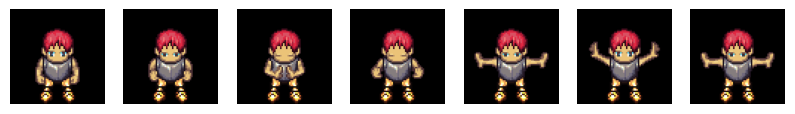

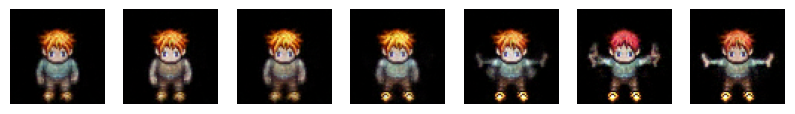

Reconstruction loss: 88.38490295410156


In [27]:
### TESTING RECONSTRUCTION ###
lldm = lldm.to('cuda')
lldm.eval()
#x = train_data[0].to('cuda').unsqueeze(0)


# z = lldm.encoder(x).embedding[0]
# _, z, _ = lldm.ddim_sampler.sample(shape = (1 , 3, 2, 2), x_last = z.reshape(1,3,2,2), cond = None)


# z = z.reshape(8,  12)
# x_rec = lldm.decoder(z).reconstruction

x = train_dataset[5672]
z_seq, x_rec = lldm.reconstruct(x, vi_index = 5)

x = x.data.unsqueeze(0)
x = x.to(x_rec.device)
plot_sequence(x.data)
plot_sequence(x_rec)

recon_loss = (
                0.5 * (
                    F.mse_loss(
                        x_rec.reshape(x.shape[0]*lldm.n_obs, -1),
                        x.reshape(x.shape[0]*lldm.n_obs, -1),
                        reduction="none"
                    )).sum(dim=-1).reshape(x.shape[0], -1)
            ).mean(dim=-1).item()

print('Reconstruction loss:', recon_loss)


In [28]:
train_embeddings = [] 

for i in range(len(train_data)):
    x = train_data[i].to('cuda').unsqueeze(0)
    z = lldm.encoder(x).embedding
    train_embeddings.append(z.cpu().detach())
train_embeddings = torch.stack(train_embeddings)

PCA on the whole dataset (56000 data points)


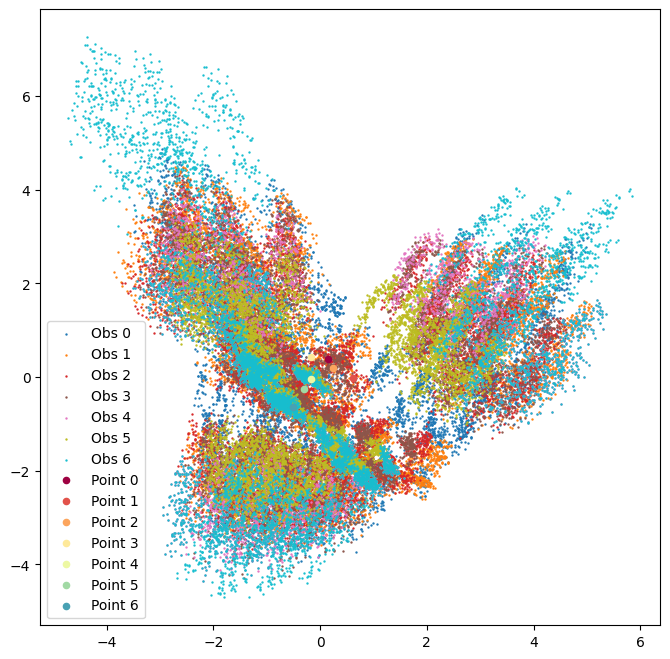

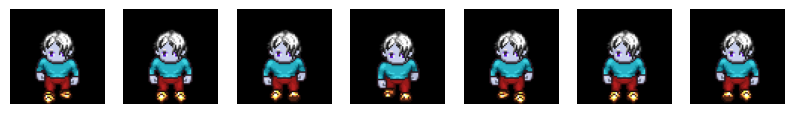

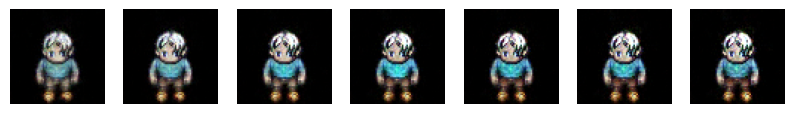

Reconstruction loss: 61.532928466796875


In [32]:
pca = PCA(n_components=2)
num_obs = train_embeddings.shape[1]
torch.manual_seed(41)

###################
vi_index = 6
projection_index = 'all' # 'all'
displayed_indexes = range(num_obs) #range(num_obs)
train_point = 456
##################


if projection_index == 'all':
    gathered = train_embeddings.reshape(-1, latent_dim)
    pca.fit(gathered)
    print(f'PCA on the whole dataset ({gathered.shape[0]} data points)')
else:
    pca.fit(train_embeddings[:, projection_index, :].reshape(-1, latent_dim))

train_embeddings_pca = []
for i in range(num_obs):
    train_embeddings_pca.append(pca.transform(train_embeddings[:, i, :].reshape(-1, latent_dim)))

train_embeddings_pca = np.stack(train_embeddings_pca).transpose(1, 0, 2)

plt.figure(figsize=(8, 8))
colors = plt.get_cmap('tab10', num_obs)
for i in displayed_indexes:
    plt.scatter(train_embeddings_pca[:, i, 0], train_embeddings_pca[:, i, 1], s=0.5, color=colors(i), label=f'Obs {i}')

x = train_dataset[train_point]
z_seq, x_rec = lldm.reconstruct(x, vi_index = vi_index)

z_seq_pca = pca.transform(z_seq.cpu().detach())
colors = plt.get_cmap('Spectral', 8)
for i in range(num_obs):
    plt.scatter(z_seq_pca[i, 0], z_seq_pca[i, 1], s=20, color=colors(i), label=f'Point {i}')

# Add legend and show plot
plt.legend()
plt.show()

x = x.data.unsqueeze(0)
x = x.to(x_rec.device)
plot_sequence(x.data)
plot_sequence(x_rec)

recon_loss = (
                0.5 * (
                    F.mse_loss(
                        x_rec.reshape(x.shape[0]*lldm.n_obs, -1),
                        x.reshape(x.shape[0]*lldm.n_obs, -1),
                        reduction="none"
                    )).sum(dim=-1).reshape(x.shape[0], -1)
            ).mean(dim=-1).item()

print('Reconstruction loss:', recon_loss)


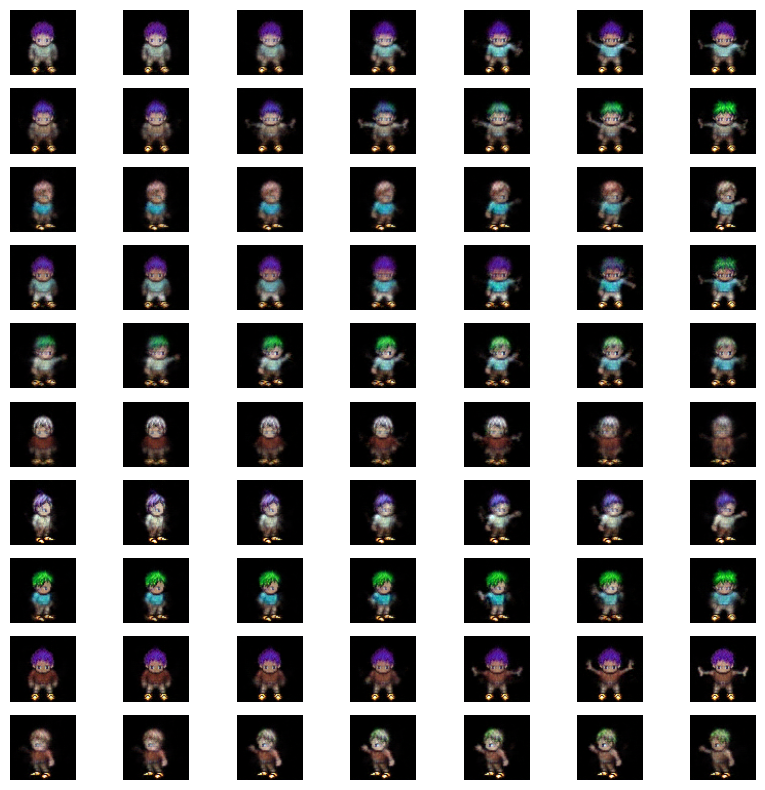

In [30]:
### TESTING GENERATION ###

lldm = lldm.to('cuda')
lldm.device = 'cuda'

lldm = lldm.eval()
recon_x = lldm.generate(10, temperature = 0.01)

plot_sequence(recon_x)

